In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-poster')

In [3]:
# From Covid Tracking API
# https://covidtracking.com/api/
api_us = 'https://covidtracking.com/api/us/daily'
api_states = 'https://covidtracking.com/api/states/daily'

# https://github.com/COVID19Tracking/associated-data
f_pop = 'associated-data/us_census_data/us_census_2018_population_estimates_states.csv'

In [4]:
df_us = pd.read_json(api_us)
df_states = pd.read_json(api_states)
df_pop = pd.read_csv(f_pop)

In [5]:
df_us.shape

(95, 24)

In [6]:
df_states.shape

(2881, 25)

In [7]:
df_pop.head()

,state,state_name,geo_id,population,pop_density
0,AL,Alabama,1,4887871,96.509389
1,AK,Alaska,2,737438,1.291523
2,AZ,Arizona,4,7171646,63.135855
3,AR,Arkansas,5,3013825,57.919684
4,CA,California,6,39557045,253.906502


In [8]:
df_us['date'] = df_us['date'].apply(
    lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
df_states['date'] = df_states['date'].apply(
    lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [9]:
df_us.sort_values(by=['date']).tail()

,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
4,2020-04-21,56,800305,3355282.0,3956.0,58468.0,84292.0,15228.0,2315.0,5514.0,...,39995.0,84292.0,4159543,4155587,4155587,2674.0,1413.0,124255.0,27285.0,151540.0
3,2020-04-22,56,827963,3641232.0,4191.0,58173.0,85543.0,15341.0,2370.0,5474.0,...,42128.0,85543.0,4473386,4469195,4469195,2133.0,1251.0,285950.0,27658.0,313608.0
2,2020-04-23,56,859318,3800932.0,4258.0,57879.0,91108.0,15163.0,2428.0,5464.0,...,44014.0,91108.0,4664508,4660250,4660250,1886.0,5565.0,159700.0,31355.0,191055.0
1,2020-04-24,56,890816,3992986.0,4396.0,56118.0,93107.0,15078.0,2468.0,5187.0,...,45786.0,93107.0,4888198,4883802,4883802,1772.0,1999.0,192054.0,31498.0,223552.0
0,2020-04-25,56,931698,4252937.0,5315.0,56312.0,94743.0,15020.0,2516.0,5266.0,...,47980.0,94743.0,5189950,5184635,5184635,2194.0,1636.0,259951.0,40882.0,300833.0


In [10]:
df_states.sort_values(by=['date']).tail()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
32,2020-04-25,NE,2421.0,17552.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,19973.0,19973.0,19973.0,31,3.0,0.0,1064.0,297.0,1361.0
31,2020-04-25,ND,803.0,18547.0,NaN,17.0,70.0,NaN,NaN,NaN,...,70.0,19350.0,19350.0,19350.0,38,1.0,3.0,1846.0,55.0,1901.0
30,2020-04-25,NC,8623.0,96642.0,NaN,456.0,NaN,NaN,NaN,NaN,...,NaN,105265.0,105265.0,105265.0,37,20.0,0.0,4110.0,571.0,4681.0
28,2020-04-25,MS,5718.0,53239.0,NaN,649.0,996.0,152.0,NaN,78.0,...,996.0,58957.0,58957.0,58957.0,28,12.0,26.0,3003.0,284.0,3287.0
0,2020-04-25,AK,339.0,15393.0,NaN,32.0,NaN,NaN,NaN,NaN,...,NaN,15732.0,15732.0,15732.0,2,0.0,0.0,3451.0,0.0,3451.0


In [11]:
# Merge in population data
df_states = pd.merge(df_states, df_pop, on='state')

# Calculate positive per 100,000
df_states['pos_rate'] = df_states['positive'] / (df_states['population'] / 1e5)

# Calculate hospitalized per 100,000
df_states['hosp_rate'] = df_states['hospitalized'] / (df_states['population'] / 1e5)

# Calculate deaths per 100,000
df_states['death_rate'] = df_states['death'] / (df_states['population'] / 1e5)

# Calculate total tests
df_states['total'] = df_states['positive'] + df_states['negative']

# Calculate percent of tests that are positive
df_states['positive_rate'] = df_states['positive'] / df_states['total']

# Calculate tests per 100,000 people
df_states['test_rate'] = df_states['total'] / (df_states['population'] / 1e5)

# Calculate 7-day average deaths
df_states['death_7dma'] = df_states['death'].rolling(window=7).mean()

In [12]:
df_states.tail()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,state_name,geo_id,population,pop_density,pos_rate,hosp_rate,death_rate,positive_rate,test_rate,death_7dma
2712,2020-03-11,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN
2713,2020-03-10,WY,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,0.0,NaN
2714,2020-03-09,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN
2715,2020-03-08,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN
2716,2020-03-07,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN


In [13]:
df_states.describe()

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,...,totalTestResultsIncrease,geo_id,population,pop_density,pos_rate,hosp_rate,death_rate,positive_rate,test_rate,death_7dma
count,2717.000000,2565.000000,551.000000,826.000000,985.000000,407.000000,172.000000,331.000000,53.000000,686.000000,...,2665.000000,2717.000000,2.717000e+03,2676.000000,2717.000000,985.000000,2027.000000,2560.000000,2565.000000,1721.000000
mean,5684.026500,25870.127875,1713.177858,1529.849879,1711.577665,761.434889,225.127907,345.752266,79.433962,1399.103499,...,1944.186116,30.025764,6.465240e+06,423.019212,70.328630,15.751625,3.579329,0.131667,540.528929,291.842948
std,20947.684039,48917.591150,8145.600142,3152.309275,7001.974126,1176.554591,222.239205,447.617774,50.978694,3924.406659,...,5012.133929,16.551212,7.236828e+06,1580.049948,148.807740,35.891328,8.661456,0.134903,642.254400,1165.190429
min,0.000000,0.000000,0.000000,10.000000,0.000000,9.000000,6.000000,4.000000,2.000000,2.000000,...,-4714.000000,1.000000,5.777370e+05,1.291523,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,45.000000,642.000000,6.000000,86.000000,57.000000,89.000000,43.000000,29.000000,39.000000,101.250000,...,52.000000,17.000000,1.805832e+06,54.955978,1.243995,3.517125,0.182125,0.053210,22.576557,8.428571
50%,585.000000,8685.000000,46.000000,307.000000,241.000000,175.000000,176.000000,99.000000,57.000000,330.000000,...,546.000000,30.000000,4.468402e+06,109.860468,22.126387,7.593306,0.946714,0.094694,326.772580,35.285714
75%,3192.000000,30008.000000,293.000000,1469.250000,760.000000,1146.500000,290.250000,507.000000,119.000000,864.500000,...,2011.000000,44.000000,7.535591e+06,229.511156,71.816733,14.250564,2.968139,0.160278,838.346262,146.571429
max,282143.000000,495425.000000,64400.000000,18825.000000,57103.000000,5225.000000,938.000000,1705.000000,170.000000,23887.000000,...,165227.000000,72.000000,3.955704e+07,11490.119540,1443.762064,292.203404,84.939221,0.924528,4813.229738,15263.857143


## California

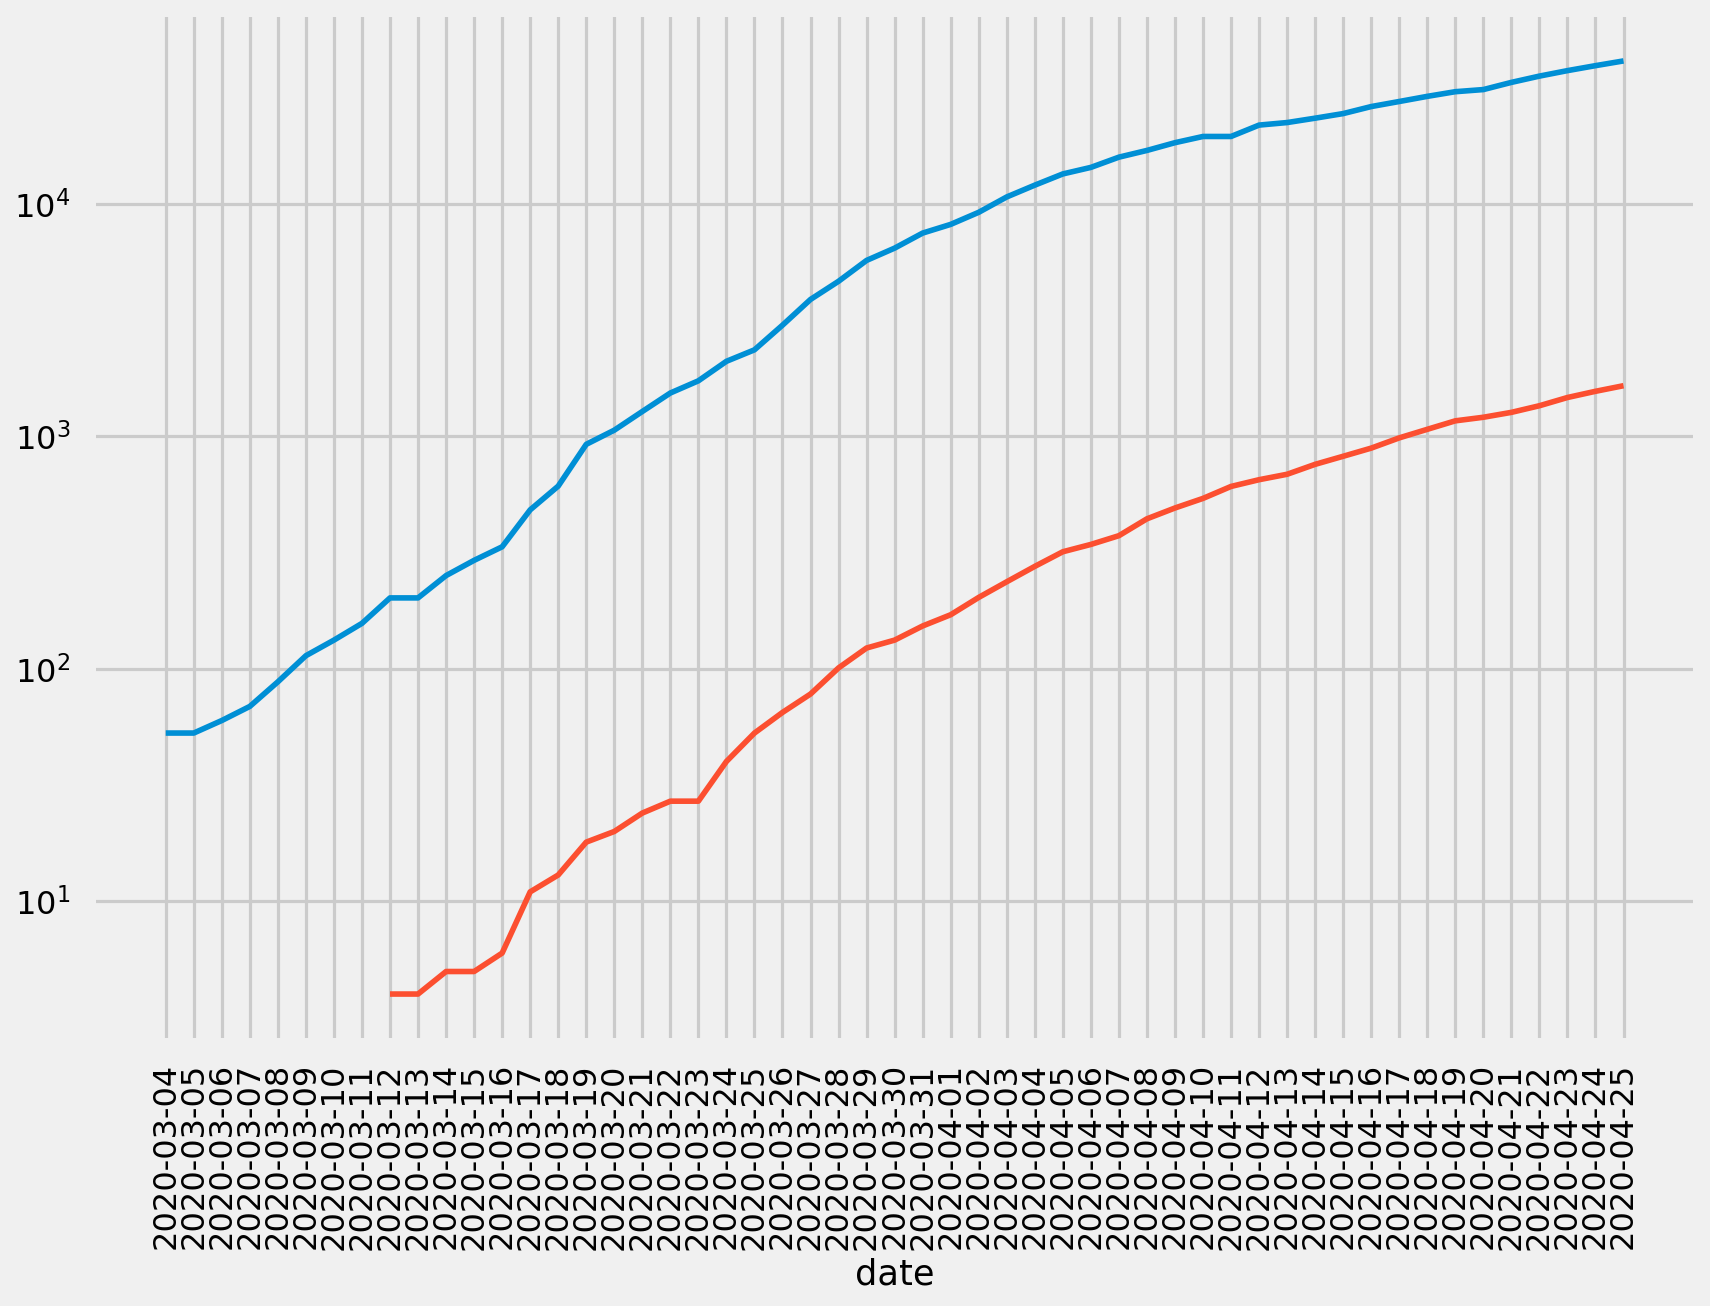

In [14]:
ax = sns.lineplot(x="date", y="positive", 
                  data=df_states.query('state == "CA"'))
ax = sns.lineplot(x="date", y="death", 
                  data=df_states.query('state == "CA"'))
ax.set(xticks=df_states.query('state == "CA"').date.values)
plt.xticks(rotation=90)
ax.set_ylabel('')
ax.set_yscale('log')
plt.show()

## New York

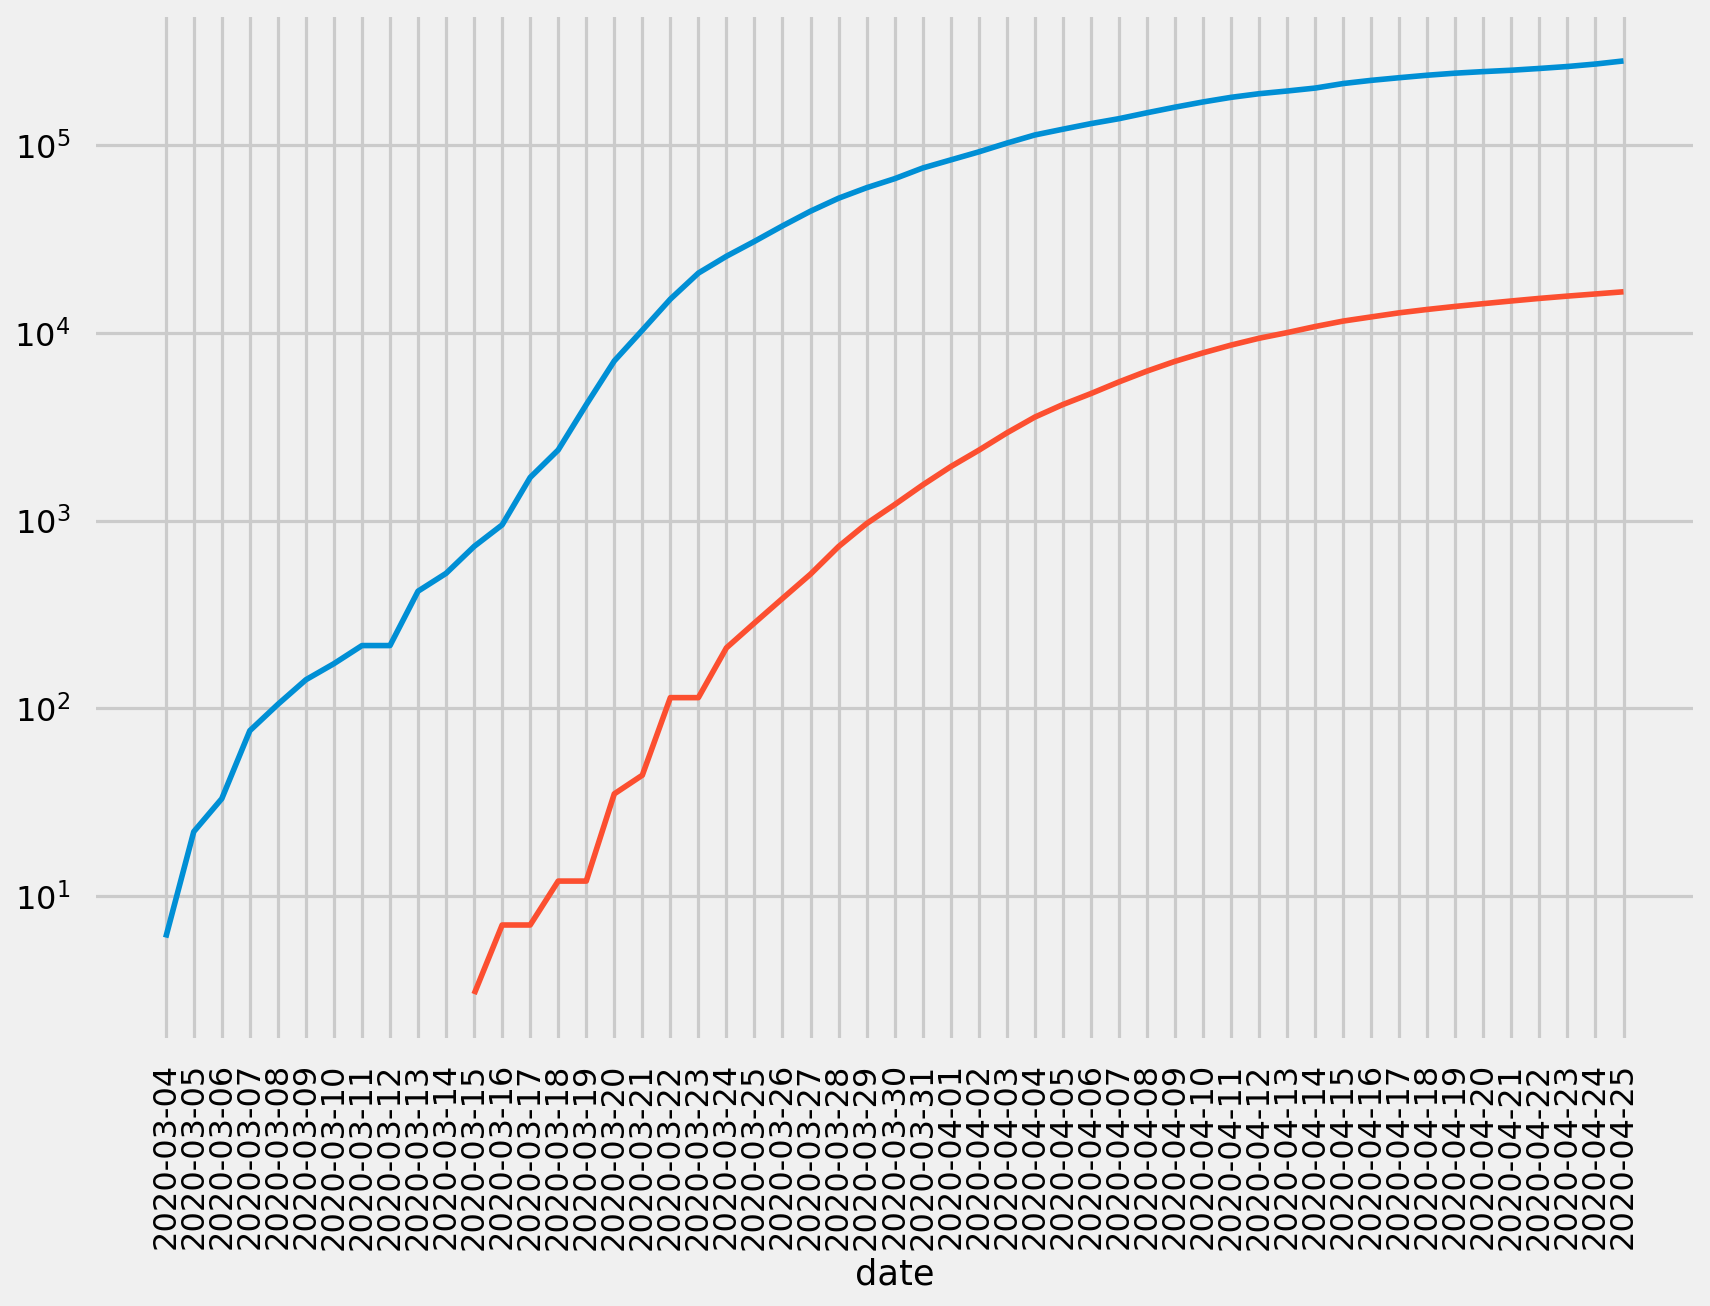

In [15]:
ax = sns.lineplot(x="date", y="positive", 
                  data=df_states.query('state == "NY"'))
ax = sns.lineplot(x="date", y="death", 
                  data=df_states.query('state == "NY"'))
ax.set(xticks=df_states.query('state == "NY"').date.values)
plt.xticks(rotation=90)
ax.set_ylabel('')
ax.set_yscale('log')
plt.show()

# Top 10 States by Deaths

In [16]:
latest_date = df_states['date'].max()
top_states = df_states.query('date == @latest_date').sort_values(by='death', 
                                                    ascending=False).state.head(10).tolist()
df_top_states = df_states.query('state == @top_states')
top_states

['NY', 'NJ', 'MI', 'MA', 'IL', 'CT', 'CA', 'LA', 'PA', 'FL']

In [17]:
df_states.query('date == @latest_date').sort_values(by='death', 
                                                    ascending=False)[['state', 'death']]

,state,death
1751,NY,16599.0
1596,NJ,5863.0
1131,MI,3274.0
976,MA,2730.0
720,IL,1874.0
310,CT,1862.0
205,CA,1651.0
926,LA,1644.0
1959,PA,1537.0
463,FL,1075.0


In [18]:
# Deaths per 100,000 people
df_states.query('date == @latest_date').sort_values(by='death_rate', 
                                                    ascending=False)[['state', 'death_rate']]

,state,death_rate
1751,NY,84.939221
1596,NJ,65.813401
310,CT,52.117957
976,MA,39.552899
926,LA,35.279137
1131,MI,32.753380
360,DC,23.489049
2051,RI,20.334527
720,IL,14.708329
1029,MD,14.480239


# Deaths

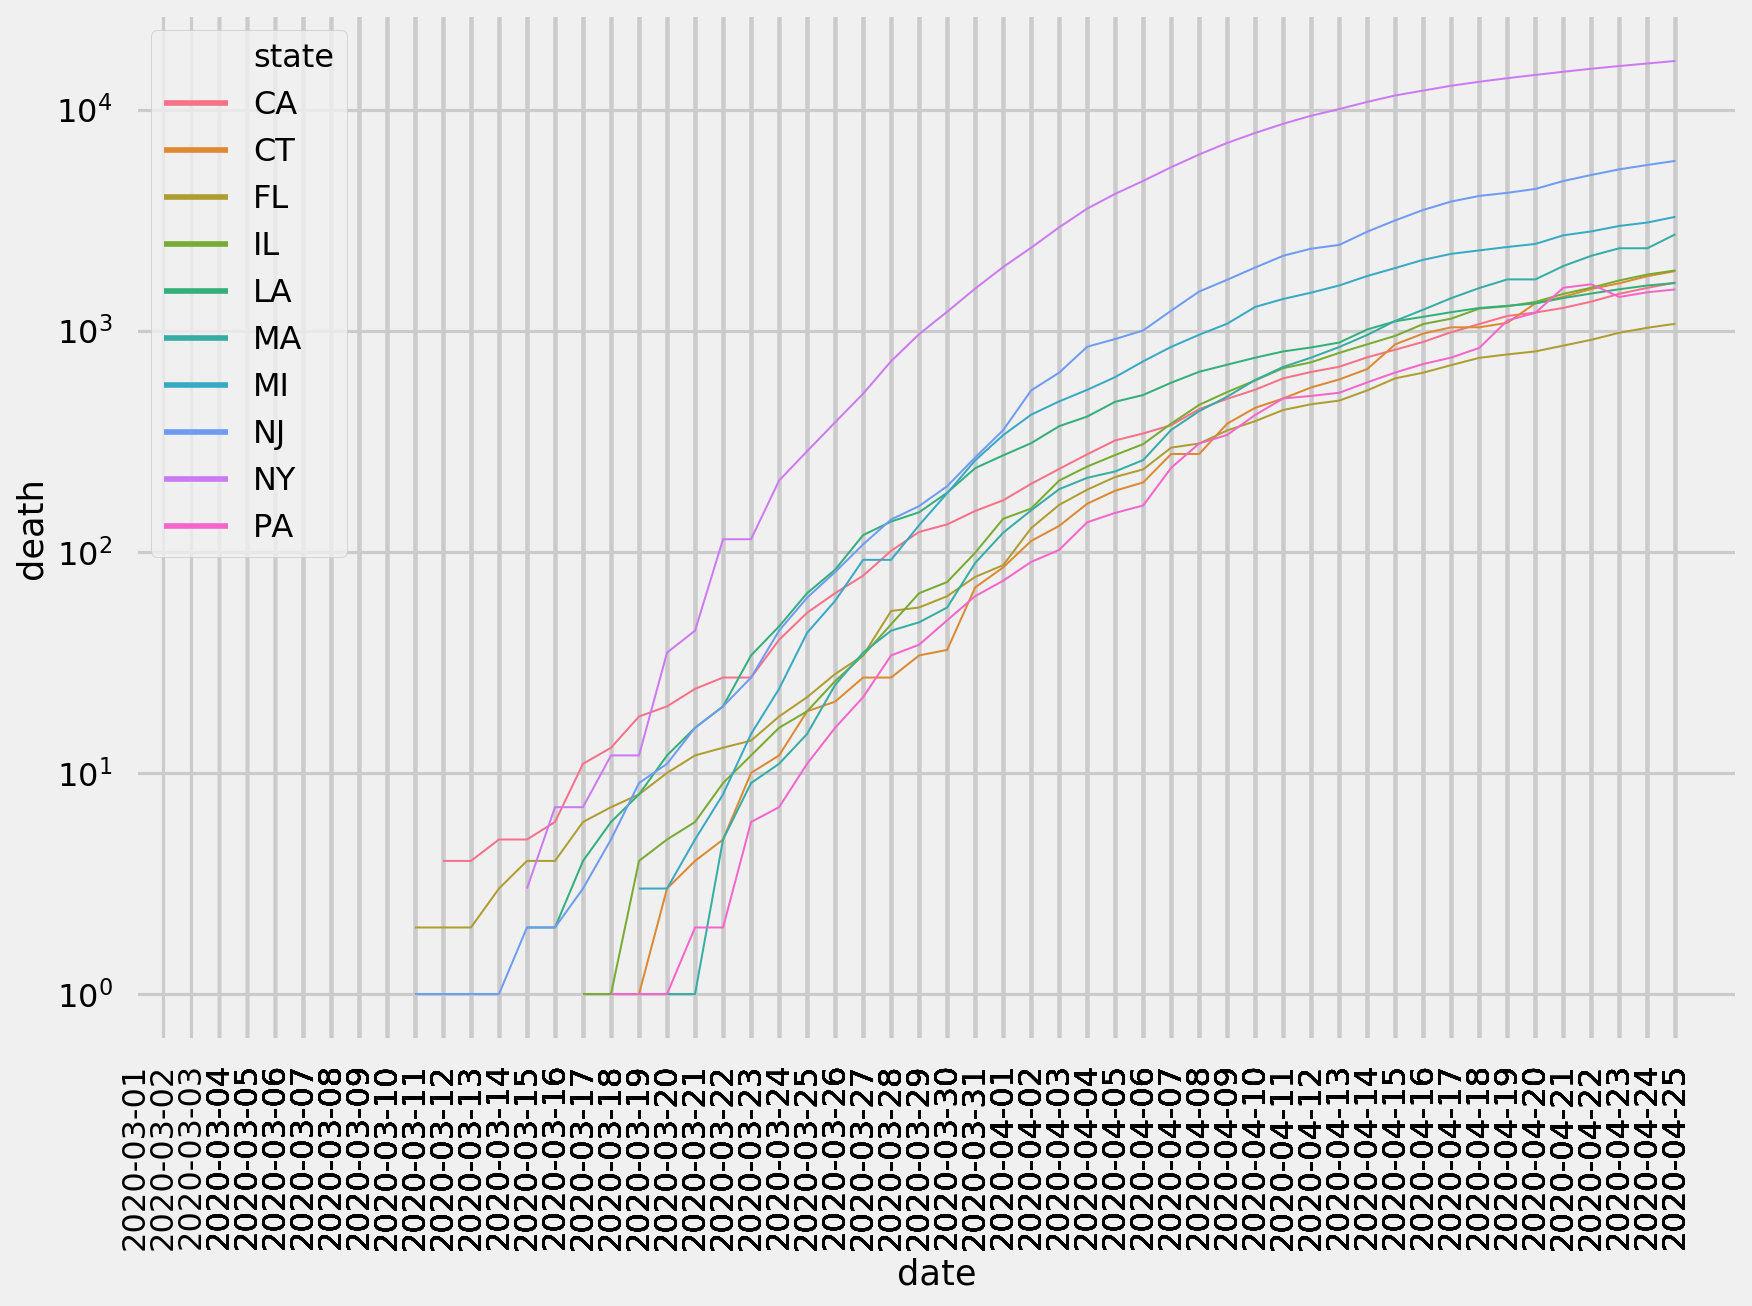

In [19]:
ax = sns.lineplot(x="date", 
                  y="death", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Deaths (7-day Moving Average)

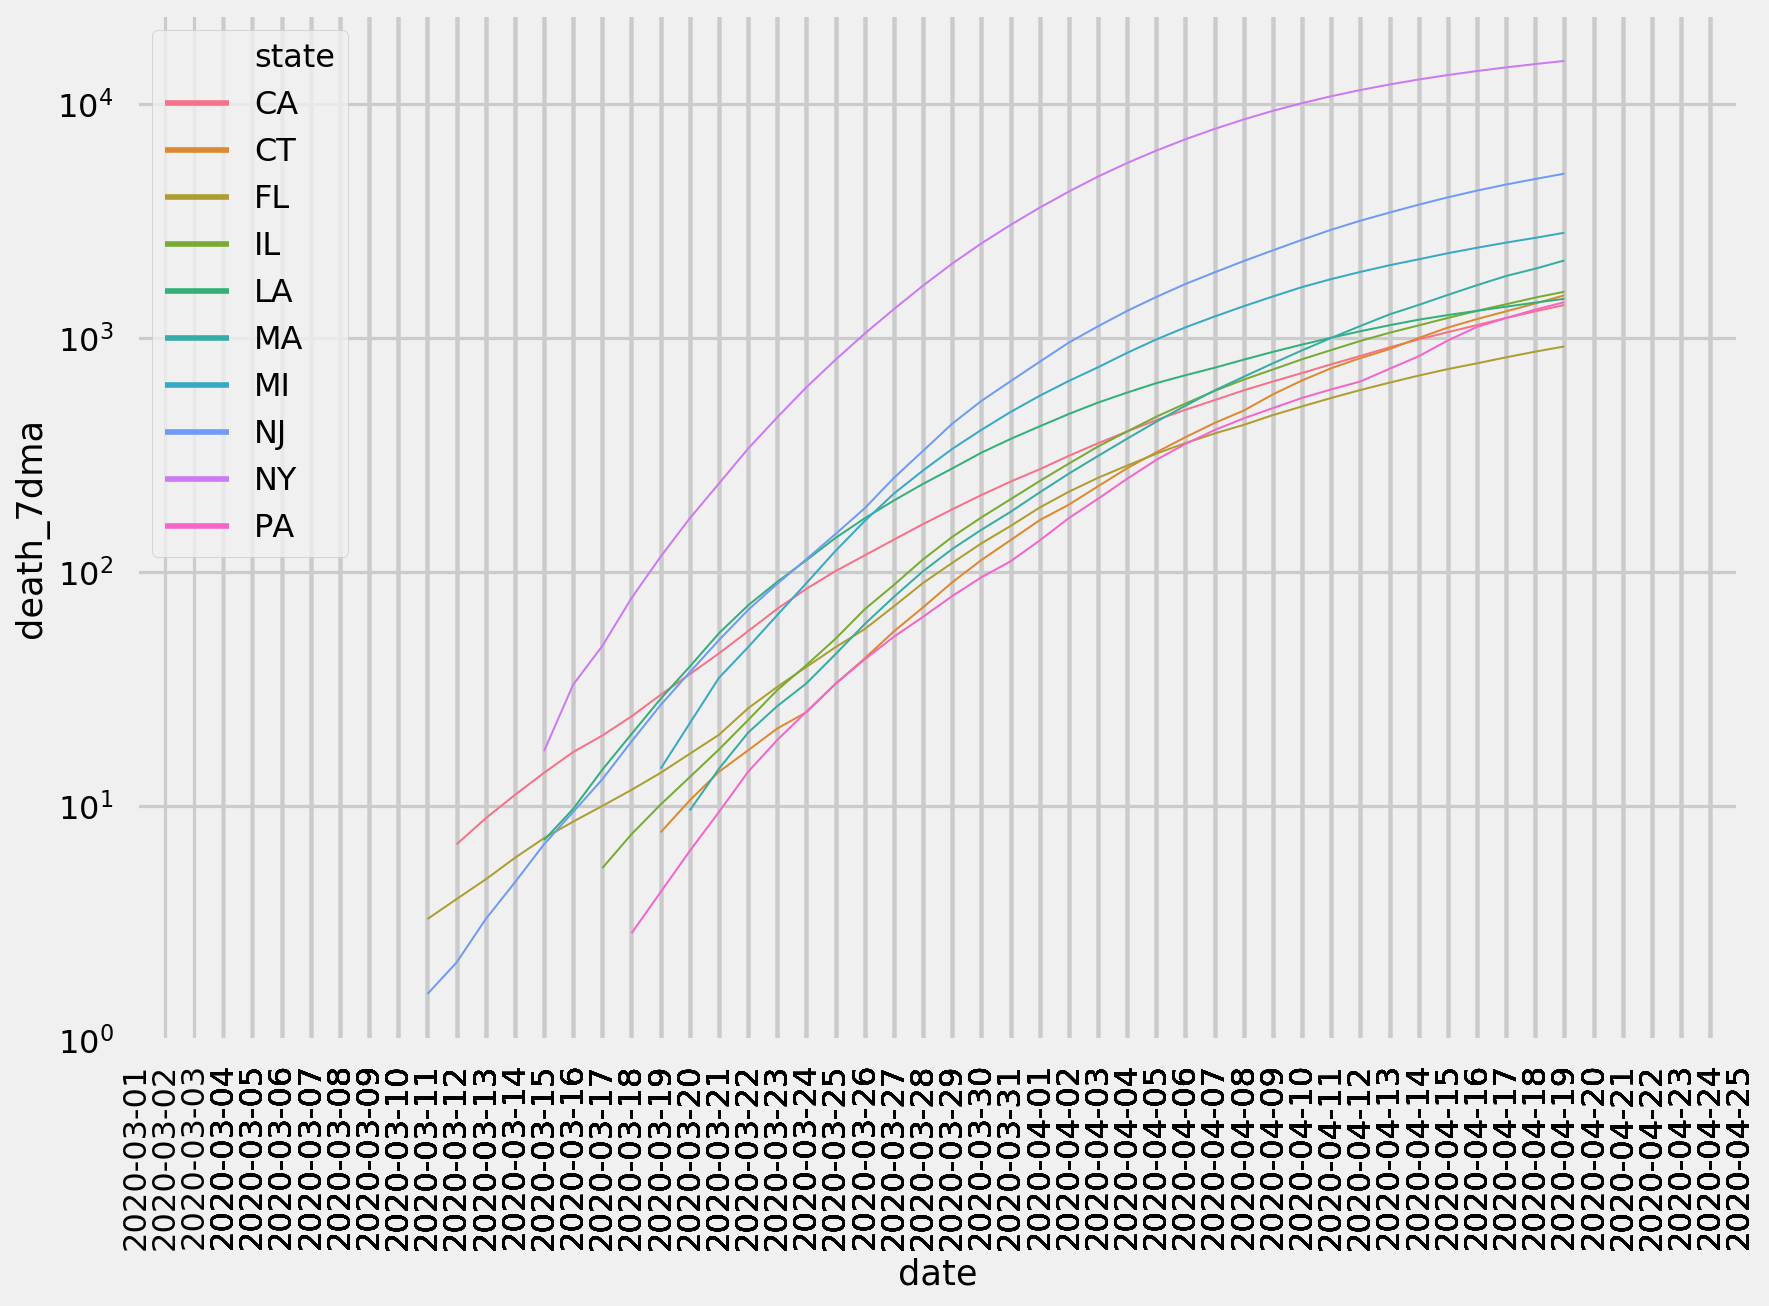

In [20]:
# TODO: index this by date first crossed 5 deaths
ax = sns.lineplot(x="date", 
                  y="death_7dma", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Positive Cases Per 100,000 People

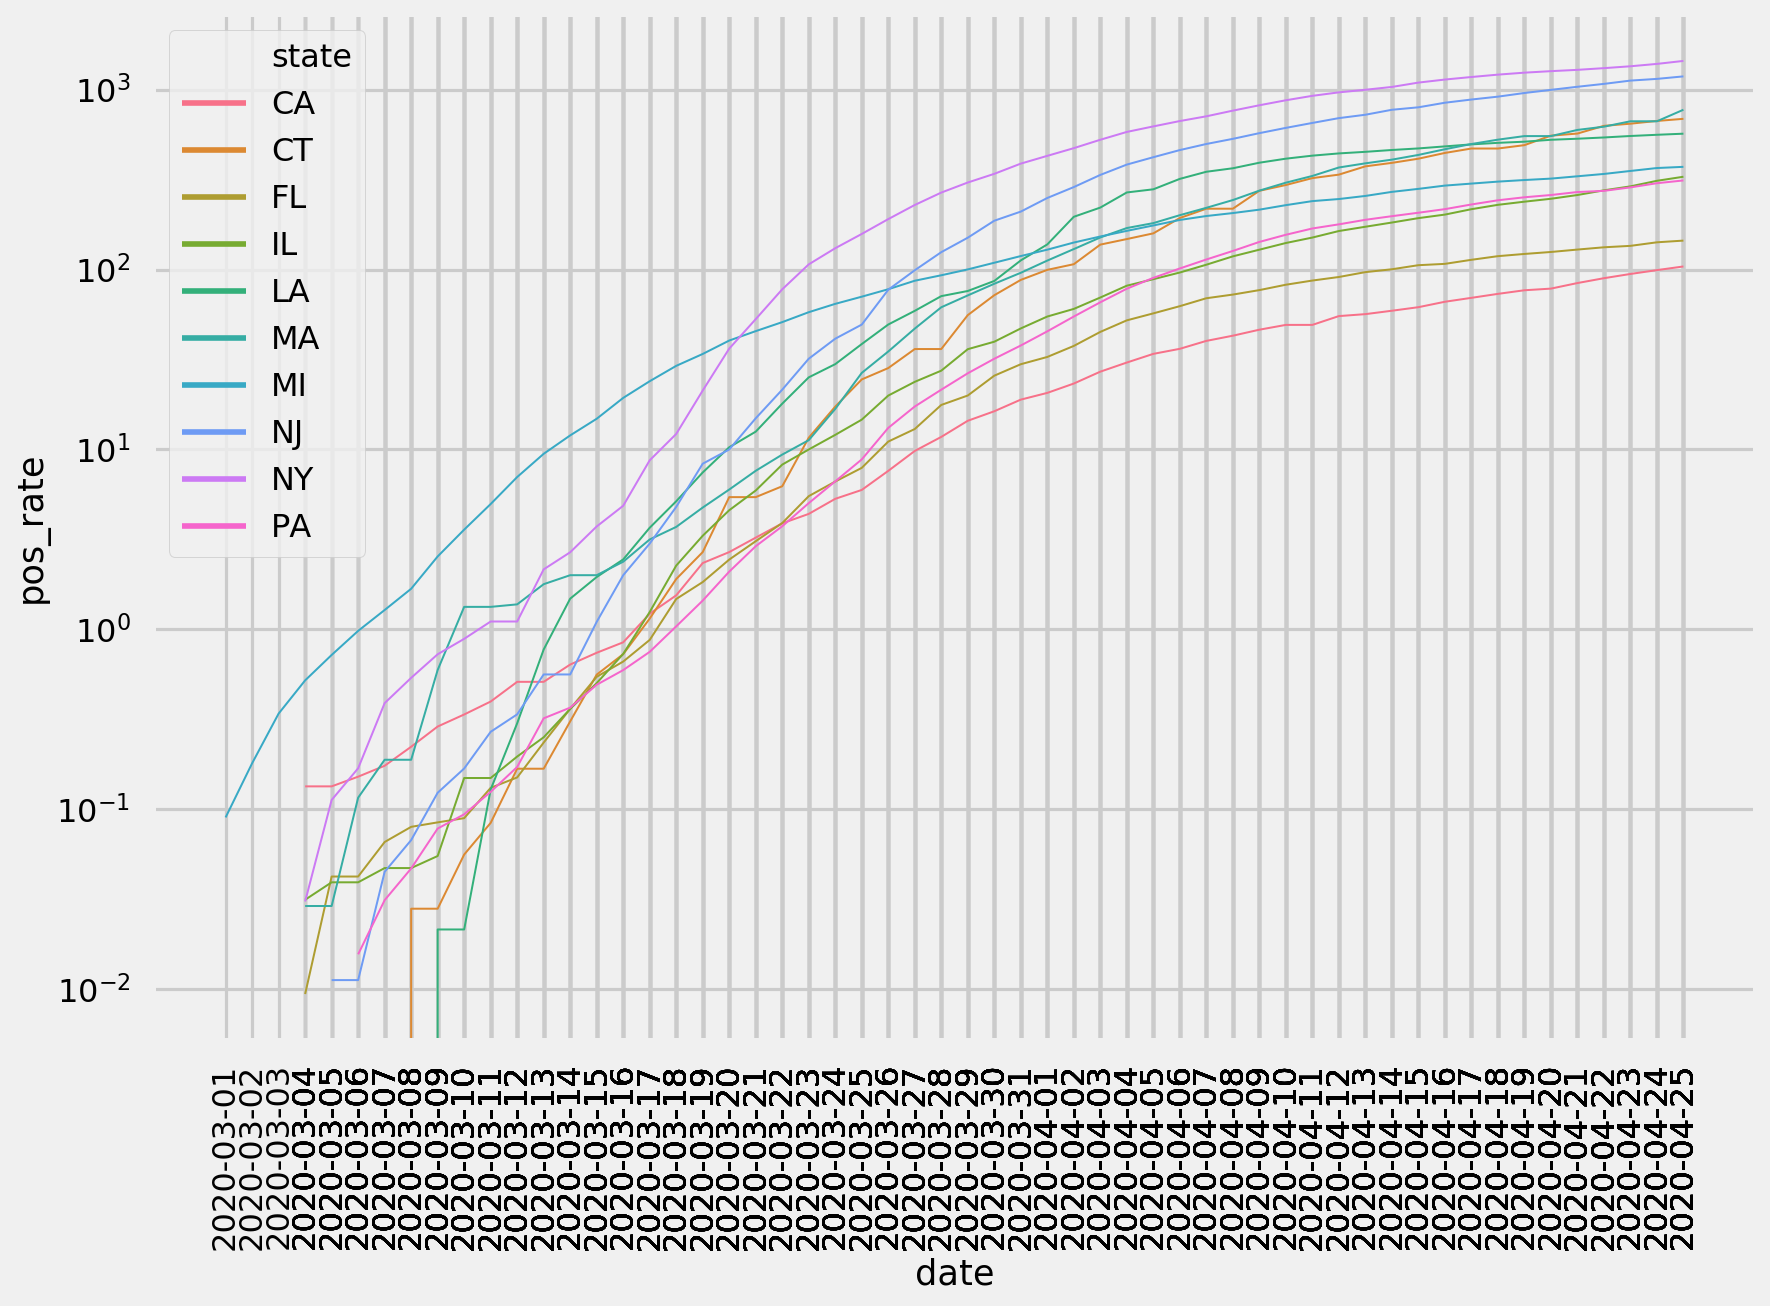

In [21]:
ax = sns.lineplot(x="date", y="pos_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Deaths Per 100,000 People

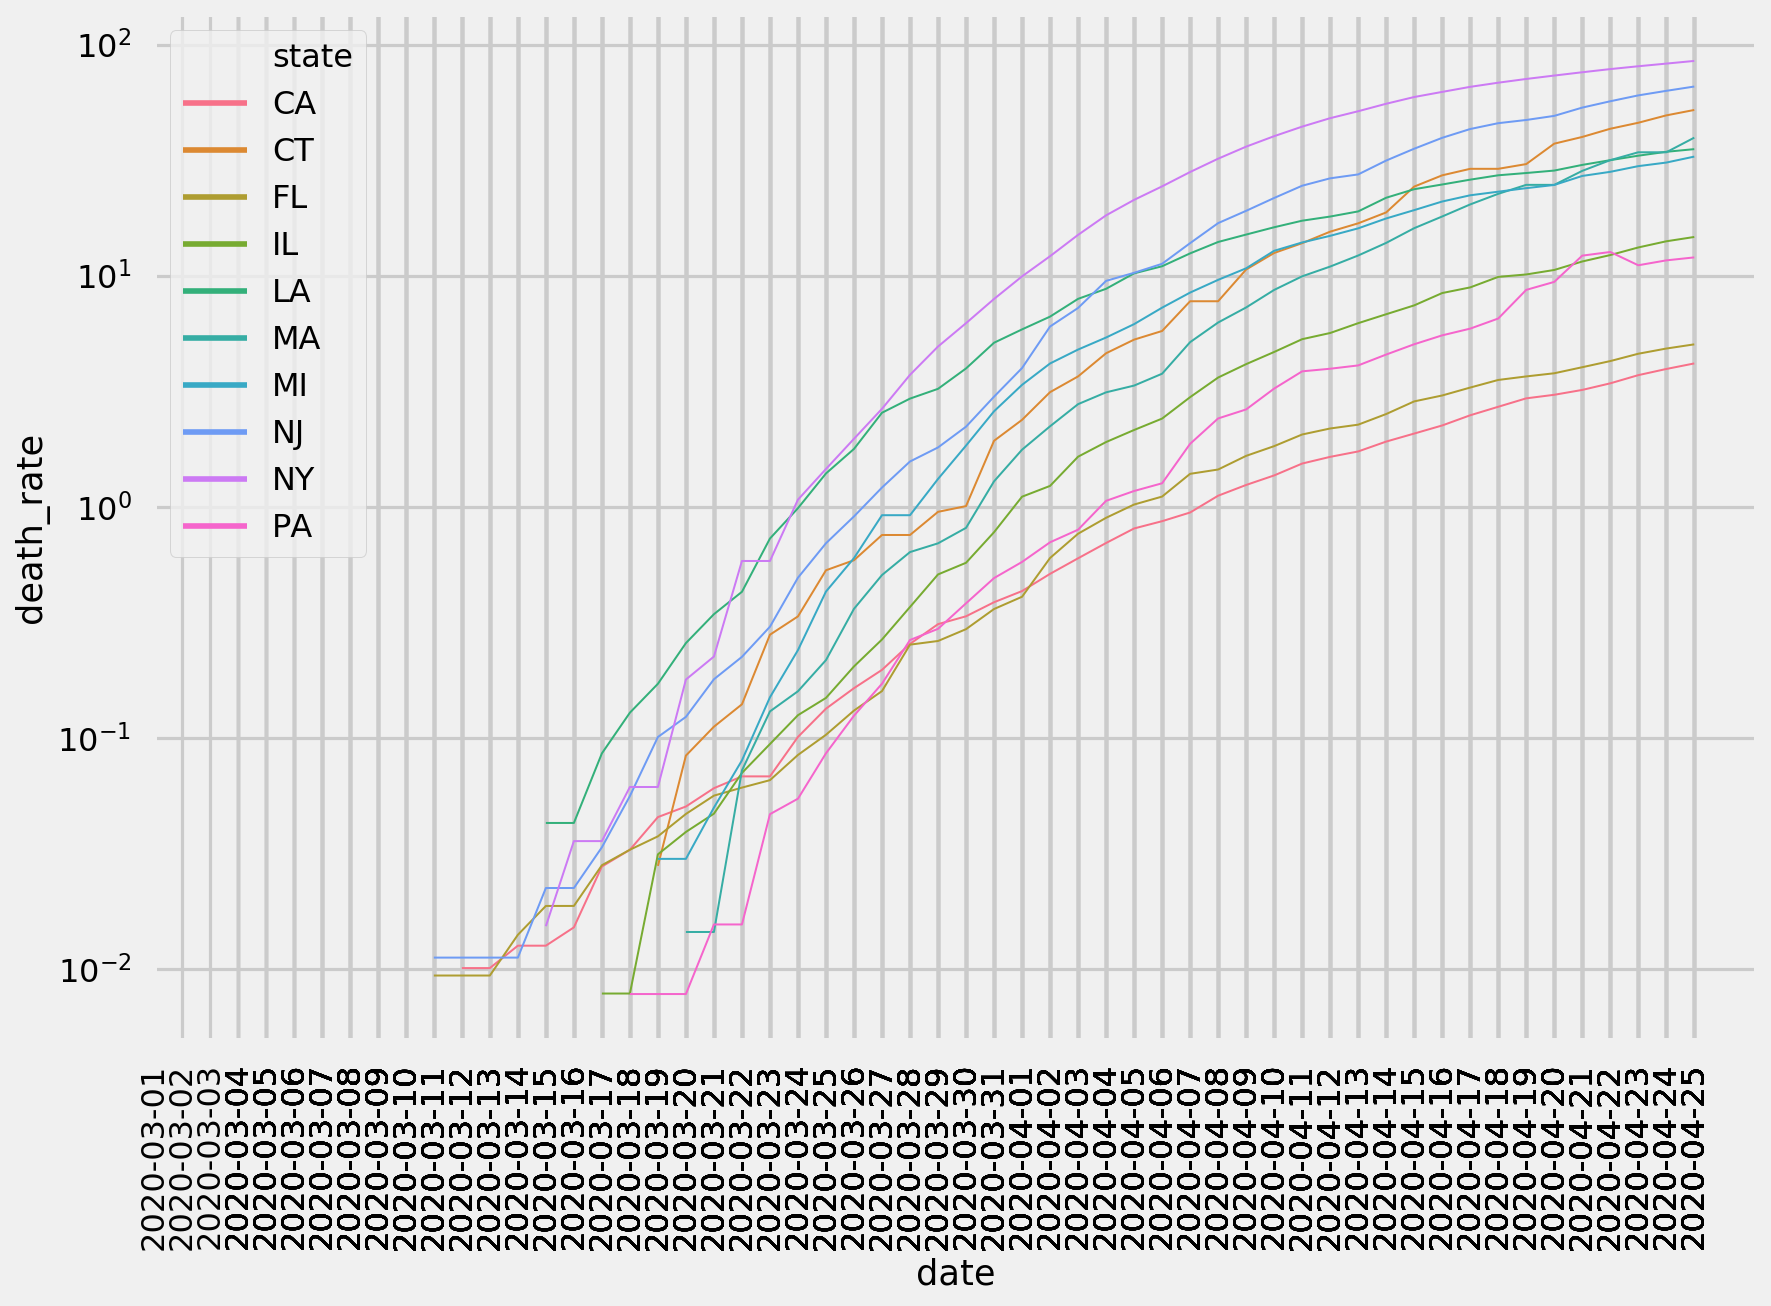

In [22]:
ax = sns.lineplot(x="date", y="death_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Tests Per 100,000 People

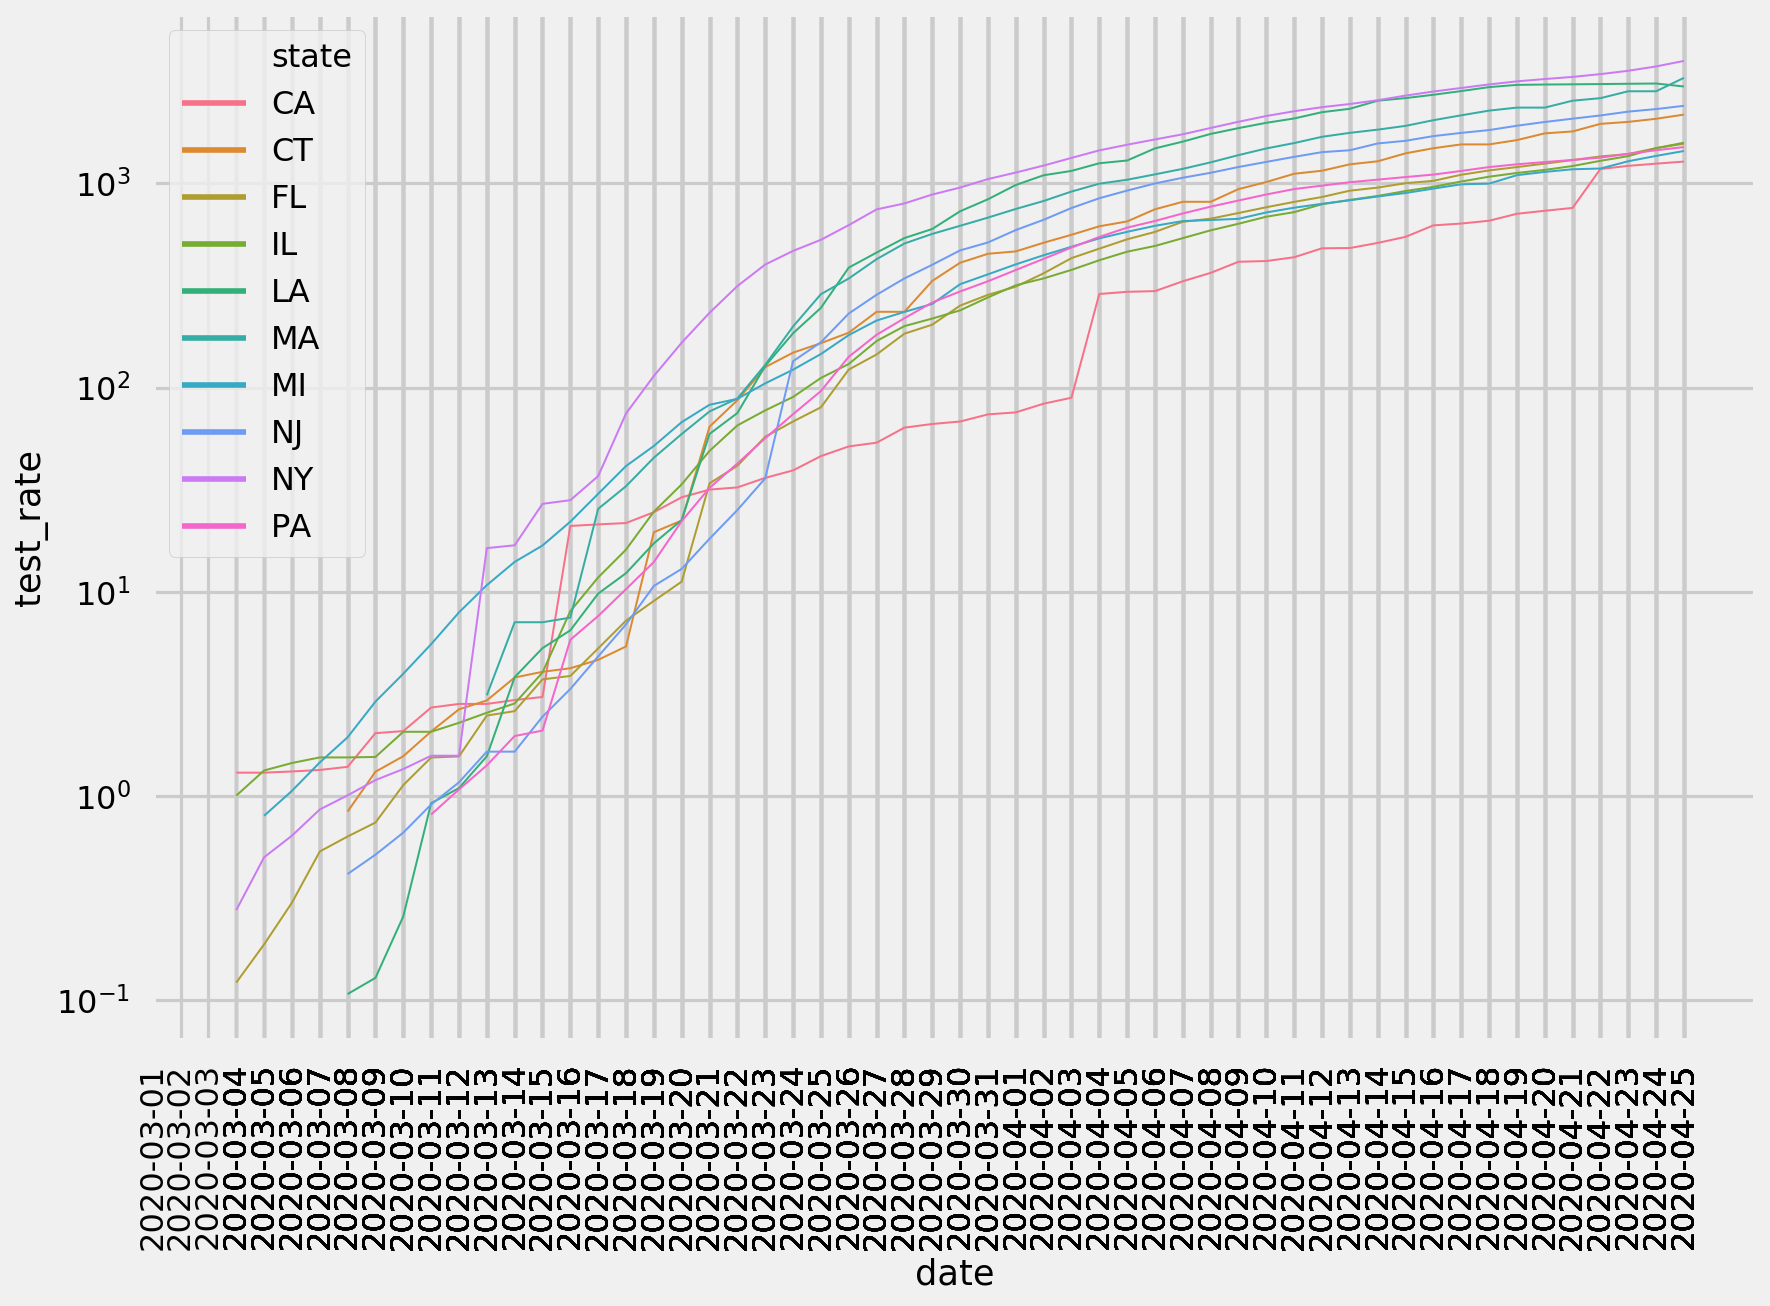

In [23]:
ax = sns.lineplot(x="date", y="test_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

In [24]:
df_states.query('date == @latest_date').sort_values(by='test_rate', 
                                                    ascending=False)[['state', 'test_rate']]

,state,test_rate
2051,RI,4813.229738
1751,NY,3978.915587
976,MA,3286.585091
926,LA,2982.889619
2315,UT,2853.622388
1441,ND,2545.794702
360,DC,2463.075927
1648,NM,2458.209015
1596,NJ,2398.670037
2417,VT,2344.247716
